In [1]:
import pandas as pd
import numpy as np
import pylab
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime, timedelta
register_matplotlib_converters()
%matplotlib inline

Let's generate some data of the form

$y_t = 0.8\epsilon_{t - 1} + 0.4\epsilon_{t - 2} + \epsilon_t$ where $\epsilon \sim N(0, 1)$

<AxesSubplot:>

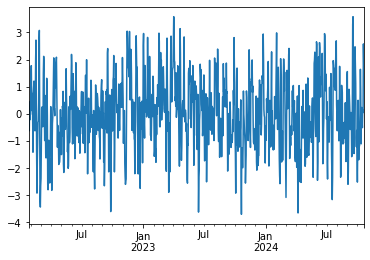

In [2]:
n = 1000

startdate = '2022-01-25'
daterange = pd.date_range(start=startdate, periods=n)

empty_dataset = np.zeros(n)
mod = SARIMAX(empty_dataset, order=(0, 0, 2), initialization='diffuse')
series = pd.Series(mod.simulate([0.8, 0.4, 1], n), index=daterange)
series.plot()

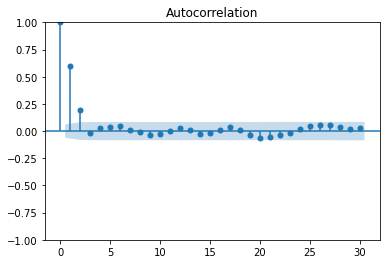

In [3]:
acf_plot = plot_acf(series)

ACF plot shuts down after two lags, this indicates a MA process

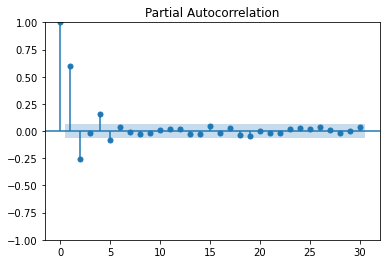

In [5]:
pacf_plot = plot_pacf(series, method='ywm')

The PACF slowly tapers off and oscillates, which confirms that it's an MA model

In [6]:
train_end = datetime(2024, 9, 1)

train_data = series[:train_end]
test_data = series[train_end + timedelta(days=1):]

In [10]:
#create the model
model = SARIMAX(train_data, order=(0, 0, 2))

In [11]:
#fit the model
model_fit = model.fit()

In [12]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  951
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -1346.854
Date:                Mon, 07 Feb 2022   AIC                           2699.709
Time:                        19:01:38   BIC                           2714.281
Sample:                    01-25-2022   HQIC                          2705.261
                         - 09-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7748      0.030     26.070      0.000       0.717       0.833
ma.L2          0.3963      0.031     12.842      0.000       0.336       0.457
sigma2         0.9939      0.045     21.855      0.0

Our predicted model is:

$\hat{y_t} = 0.77\epsilon_{t - 1} + 0.40\epsilon_{t - 2} + \epsilon$ where $\epsilon \sim N(0, 0.99)$

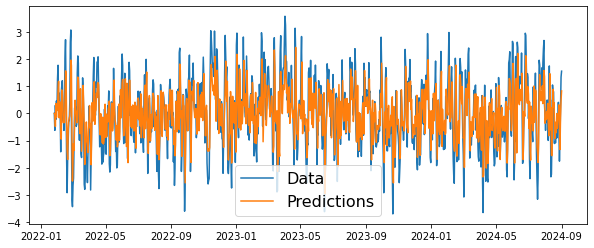

In [13]:
pylab.figure(figsize=(10,4))

pylab.plot(train_data)
pylab.plot(model_fit.predict(start=train_data.index[0], end=train_data.index[-1]))

pylab.legend(('Data', 'Predictions'), fontsize=16)

In [91]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [92]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)

Text(0.5, 1.0, 'MA2 Simulation over time')

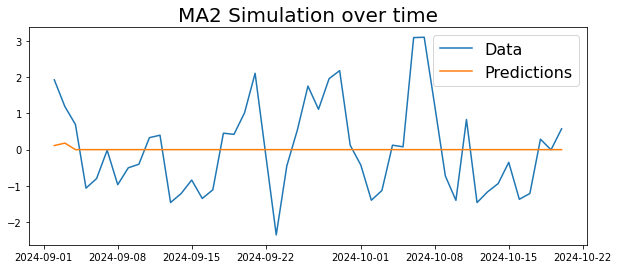

In [104]:
pylab.figure(figsize=(10,4))

pylab.plot(test_data)
pylab.plot(predictions)

pylab.legend(('Data', 'Predictions'), fontsize=16)

pylab.title('MA2 Simulation over time', fontsize=20)

In [94]:
residuals = test_data - predictions

In [102]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.9957


In [103]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1.2416695270382967


Text(0, 0.5, 'Error')

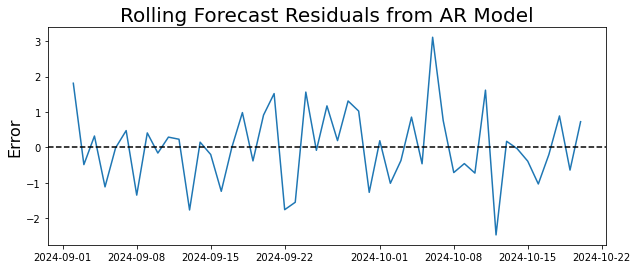

In [97]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = series[:train_end - timedelta(days=1)]
    model = SARIMAX(train_data, order=(0,0,2))
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred
    
rolling_residuals = test_data - rolling_predictions
pylab.figure(figsize=(10,4))
pylab.plot(rolling_residuals)
pylab.axhline(0, linestyle='--', color='k')
pylab.title('Rolling Forecast Residuals from AR Model', fontsize=20)
pylab.ylabel('Error', fontsize=16)

In [100]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 4.9827


In [101]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 1.0625795652625891
